# SARSA for Taxi-v3 environment

## Step 1 - Import Libraries

In [40]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note need to 'pip install gym', and 'pip install gym[toy_text]' 
                                 # or 'pip install gym\[toy_text\]' if zsh does nor recongize the first command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version

from IPython import display # for displaying environment states

numpy: 1.21.5
gym: 0.26.2
matplotlib: 3.5.3


## Step 2 - Setup the Environment

We will use Taxi-v3 environment. There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

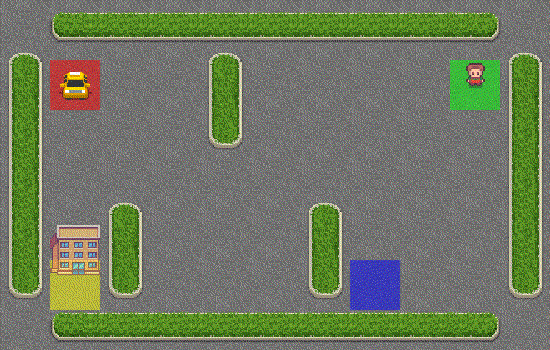

- Source: https://www.gymlibrary.dev/environments/toy_text/taxi/

##### Setup environment

In [41]:
# Setup environment
env = gym.make(id='Taxi-v3', # choose one of the existing environments
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

##### Show environment description (map) as an array

In [42]:
env.desc

array([[b'+', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'+'],
       [b'|', b'R', b':', b' ', b'|', b' ', b':', b' ', b':', b'G', b'|'],
       [b'|', b' ', b':', b' ', b'|', b' ', b':', b' ', b':', b' ', b'|'],
       [b'|', b' ', b':', b' ', b':', b' ', b':', b' ', b':', b' ', b'|'],
       [b'|', b' ', b'|', b' ', b':', b' ', b'|', b' ', b':', b' ', b'|'],
       [b'|', b'Y', b'|', b' ', b':', b' ', b'|', b'B', b':', b' ', b'|'],
       [b'+', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'+']],
      dtype='|S1')

##### Show state (observation) space and action space

In [43]:
# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

State(Observation) space: Discrete(500)
Action space: Discrete(6)


In [44]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

Environment Array: 
[[b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']
 [b'|' b'R' b':' b' ' b'|' b' ' b':' b' ' b':' b'G' b'|']
 [b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b':' b' ' b':' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b'|']
 [b'|' b'Y' b'|' b' ' b':' b' ' b'|' b'B' b':' b' ' b'|']
 [b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']]
State(Observation) space: Discrete(500)
Action space: Discrete(6)


### Actions
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

### Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination)

An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the “decode” method.

Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

### Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

## Step 3 - Interacting with the Environment

Functions of the Env class that help the agent interact with the environment.

- <b>reset:</b> This function resets the environment to its initial state, and returns the observation of the environment corresponding to the initial state.
- <b>step:</b> This function takes an action as an input and applies it to the environment, which leads to the environment transitioning to a new state. The step function returns four things:
    - <b>observation/state:</b> The state(observation) of the environment.
    - <b>reward:</b> The reward that you can get from the environment after executing the action that was given as the input to the step function.
    - <b>done:</b> Whether the episode has been terminated. If true, you may need to end the simulation or reset the environment to restart the episode.
    - <b>info:</b> This provides additional information depending on the environment, such as number of lives left, or general information that may be conducive in debugging.

##### Reset environment to initial state

In [45]:
# Reset environment to initial state
state, info = env.reset()

# Print the state(observstion) of the environment
print("The initial state is {}".format(state))

# Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination)
#for i in range (0,500):
#    print("state:",i, "represents:", list(env.decode(i)))

The initial state is 282


##### Take random actions and visualise

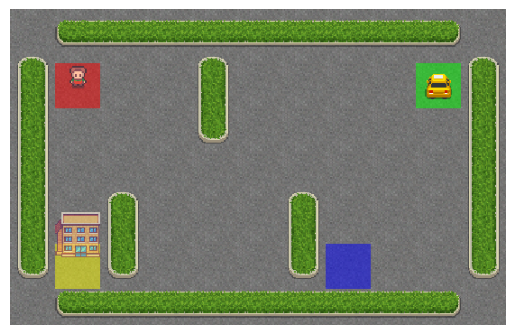

In [46]:
# Adjust default figure size parameter in matplotlib
# plt.rcParams["figure.figsize"] = [10.0, 8.0]

# Cycle through 30 random steps redering and displaying the agent inside the environment each time
for _ in range(30):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Sample a random action from the entire action space
    random_action = env.action_space.sample()
    
    # Pass the random action into the step function
    state, reward, done, _, info = env.step(random_action)
    
    # Reset environment when done=True, i.e., when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display current state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        # Reset environment
        state, info = env.reset()

# Close environment 
env.close()

## Step 4 - Train a model, i.e., find optimal Policy (π)

### SARSA algorithm

#### $Q(S_{t},A_{t}) = Q(S_{t},A_{t}) + \alpha [R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})]$


- Q - Q-function (note, Q stands for "Quality")
- $S_{t}$ - current state(observation)
- $A_{t}$ - current action
- $R_{t+1}$ - reward received following current action
- $S_{t+1}$ - next state(observation)
- $A_{t+1}$ - next action
- $\alpha$ (alpha) - learning rate parameter
- $\gamma$ (gamma) - discount factor parameter

##### Initialize parameters

In [47]:
# SARSA parameters
alpha = 0.1   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 100000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.0   # the lowest epsilon allowed to decay to
decay_rate = 0.00001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves


##### Initialize the Q-table

In [48]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 500 x 6
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

##### Define functions to choose actions and to update Q
- SARSA is an on-policy algorithm. Hence, we will use the same epsilong-greedy strategy to act and to update the Q table. 
    - epsilon-greedy function will give us an action
    - while update_Q function will update Q after each interation (since SARSA uses Temporal Difference (TD) approach)

In [49]:
# This is our acting policy (epsilon-greedy), which selects an action for exploration/exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwise exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action

In [50]:
# This function is to update the Qtable.
# It is also based on epsilon-greedy approach because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    return Qtable

##### Define another function that gives us action based on greedy policy (we will use it when evaluating results)

In [51]:
# Always go for the highest value (state,action) pair
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

##### Define a traning function

In [52]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
    # Return final Q-table
    return Qtable

##### Find the optimal policy by running the training algorith (Train)

In [53]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-16.06561258, -14.19329161, -17.63242287, -14.50655595,
        -12.0706676 , -22.72162449],
       [ -4.94905133,  -2.82851062,  -6.91923362,  -1.57552359,
          1.28205243, -11.59772958],
       ...,
       [ -2.75569288,   2.23301668,  -1.08707393,  -5.5488424 ,
        -11.46145268, -10.87461325],
       [-17.34925719, -12.93619464, -16.87492281, -10.75216426,
        -24.00699391, -29.27336212],
       [  7.85306727,   6.36819705,   9.3015024 ,  15.7984928 ,
          0.29697781,   2.60122695]])

## Step 5 - Evaluate the value function to see if we managed to find the best policy

We will use our final Q-table and eval_greedy function that returns an action with the highest value for an input state

##### Evaluate agent by calculating mean rewards over a specified number of episodes (say, 10000 episodes)

In [54]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward += reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards

Mean Reward = 7.94 +/- 2.59
Min = 3.0 and Max 15.0


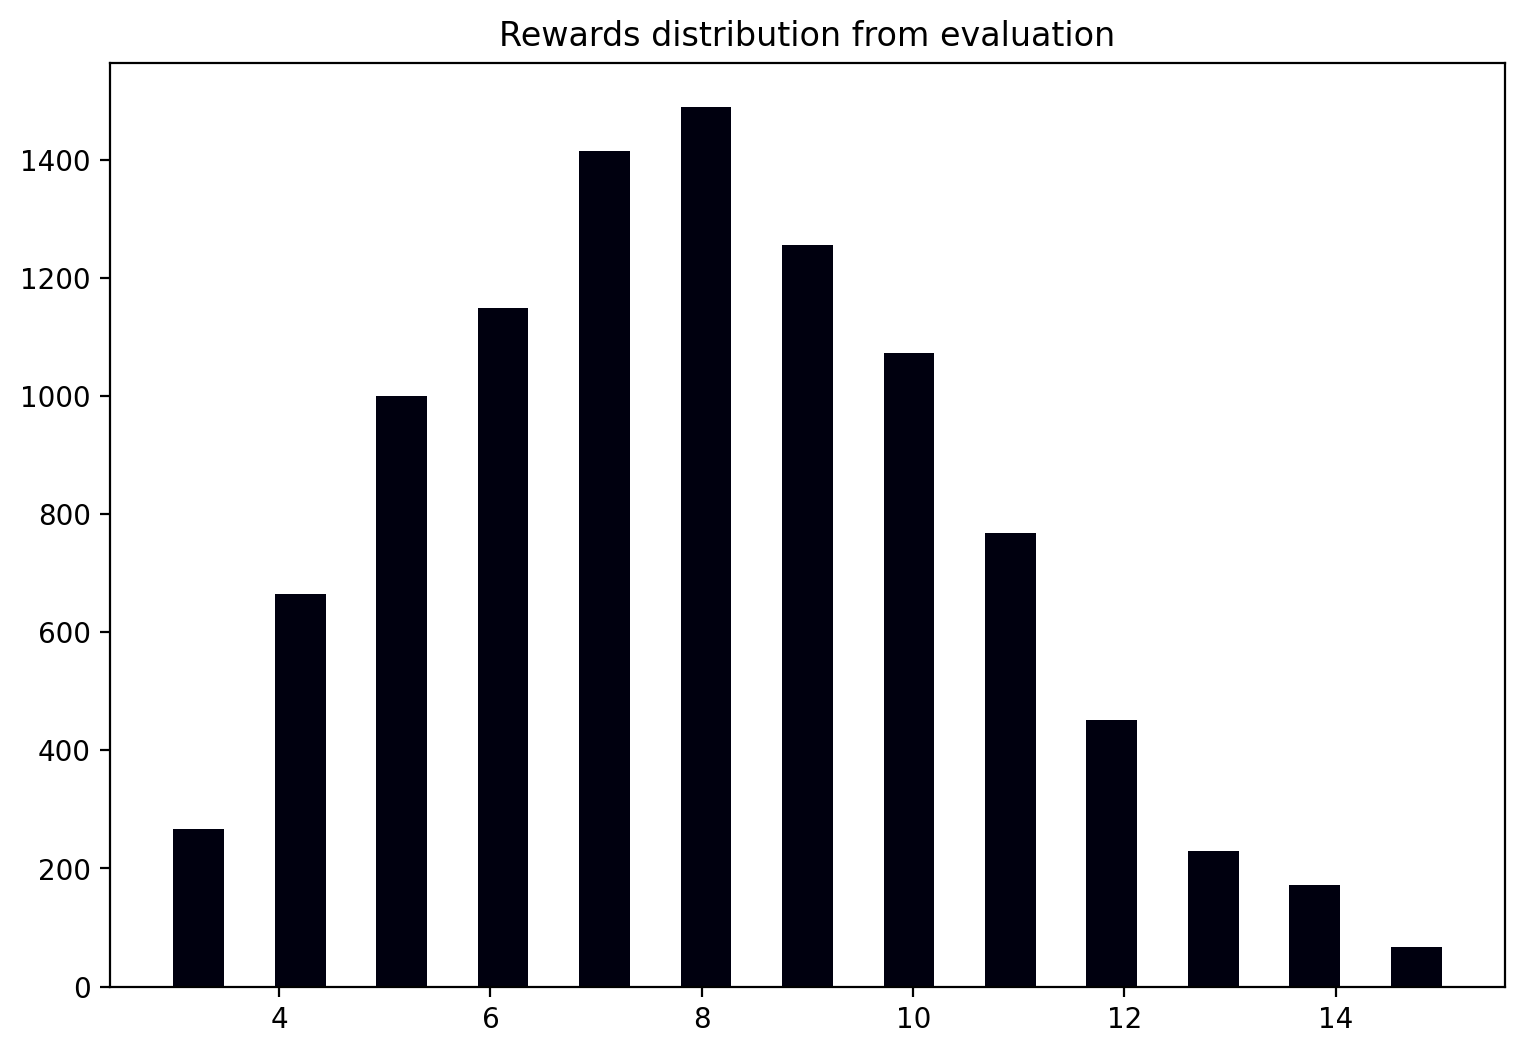

In [55]:
# Evaluate
n_eval_episodes=10000
mean_reward, std_reward, episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)

# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")

# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=25, color='#00000f')
plt.show()

##### Now let's also render the steps that the agent takes using our optimised Q-table

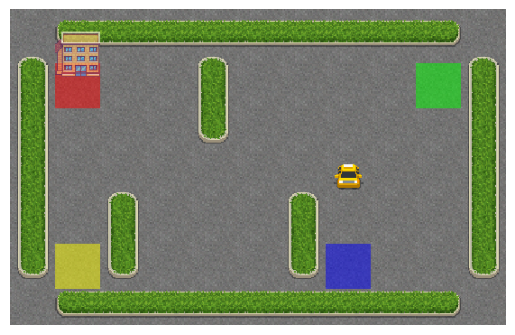

In [56]:
# Reset environment to initial state
state, info = env.reset()

# Cycle through 50 steps redering and displaying environment state each time
for _ in range(50):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()

# End of Program